# Challenge kaggle : bike sharing demand
Maxime Millavet

https://www.kaggle.com/c/bike-sharing-demand

## Objectifs
L'objectif ici est de prédire le nombre de vélo loués par heure en ville à partir du dataset donné. L'étude est donc un problème de regression et passera par trois étapes, l'analyse, la modélisation et enfin un retour critique sur les résultats.

### Bibliothèques

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline

### Lecture des données

In [6]:
original_dataset = pd.read_csv("./data/train.csv")

## Exploration des données
### Rappel : description des données
- datetime - hourly date + timestamp
- season :
  1. winter : January - March
  2. spring : April - June
  3. summer : July - September
  4. fall : October - December
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather :
  1. Clear, Few clouds, Partly cloudy
  2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds
  3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

Il est à noter que dans la description originale du dataset la valeur 1 de la colonne weather correspondait au printemps, ce qui ne correspond pas au valeurs renseignées dans le dataset. J'ai donc modifié la description en conséquence. Dans le cadre de ce travail je n'ai également pas du tout pris en compte les colonnes casual et registered.

Nous commençons tout d'abord par afficher les premières lignes du dataset.
La valeur à prédire correspond à la colonne count, c'est un int positif.
On observe tout d'abord que le dataset contient majoritairement des int ou des float mais aussi un datetime.

On s'intéresse tout d'abord à la valeur datetime. il pourrait être intéressant de séparer cette valeur en plusieurs pour mieux cerner les influences périodiques. Il serait notamment intéressant de regarder comment les locations de vélo évoluent en fonction de l'heure ainsi que d'une année à l'autre.

La valeur de saison pourrait être redondante avec le mois. Il serait plus intéressant d'utiliser un encodage de type one hot pour ce genre de valeur cyclique. Il peut en revanche être intéressant de garder la colonne weather comme telle car les valeurs correspondantes représentent un niveau de couverture du ciel et donc une gradation.

Les colonnes temp et atemp sont fortement liées et il n'est peut-être pas nécessaire de garder les deux.

In [7]:
original_dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Les données correspondent aux années 2011 et 2012 et il y a plus de 10000 lignes.

In [8]:
original_dataset.tail(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10876,2012-12-19 14:00:00,4,0,1,1,17.22,21.210,50,12.9980,33,185,218
10877,2012-12-19 15:00:00,4,0,1,1,17.22,21.210,50,19.0012,28,209,237
10878,2012-12-19 16:00:00,4,0,1,1,17.22,21.210,50,23.9994,37,297,334
10879,2012-12-19 17:00:00,4,0,1,1,16.40,20.455,50,26.0027,26,536,562
10880,2012-12-19 18:00:00,4,0,1,1,15.58,19.695,50,23.9994,23,546,569
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


En regardant le dataset on s'aperçoit qu'aucune donnée n'est manquante.

In [9]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Il n'y aura donc ici pas besoin de compléter les données par un calcul de moyenne ou une interpolation.

### Outliers
Nous allons vérifier que le dataset ne contient pas de valeurs aberrantes.

In [10]:
original_dataset.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Les données ne comportent pas d'erreurs de manière générale. La colonne season est diffcilement interprétable sous cet forme mais on voit que la répartition entre les 4 saisons est égale. Il y a 2% de jours fériés, on oberve aussi que le nombre moyen de jours de semaine correspond bien à 5/7 et que la météo correspond dans 75% des cas à un niveau 1 ou 2 seulement alors que les températures sont plus équitablement réparties. On pourra éventuellement détecter des outliers durant la visualisation des données.

# Modification des features
Comme annoncé précedemment nous allons décomposer la donnée datetime pour voir si le paramètre count subit des influences périodiques. Nous allons égalemnt considérer les saisons en one hot.
Les colonnes datetime et season seront retirées plus tard dans une copie du dataset.

In [11]:
df = original_dataset.copy()
df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%dT%H')

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

df = pd.concat([df, pd.get_dummies(df['season'], prefix='season')],axis=1)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,season_1,season_2,season_3,season_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,1,0,0,0


# Influence des features
Nous allons voir quelles données influent le plus sur la donneé cible. On cherche tout d'abord à savoir si des phénomènes périodiques influent sur la location de vélos.
Pour cela on trace le nombre de locations tout au long de la période de collecte des données.

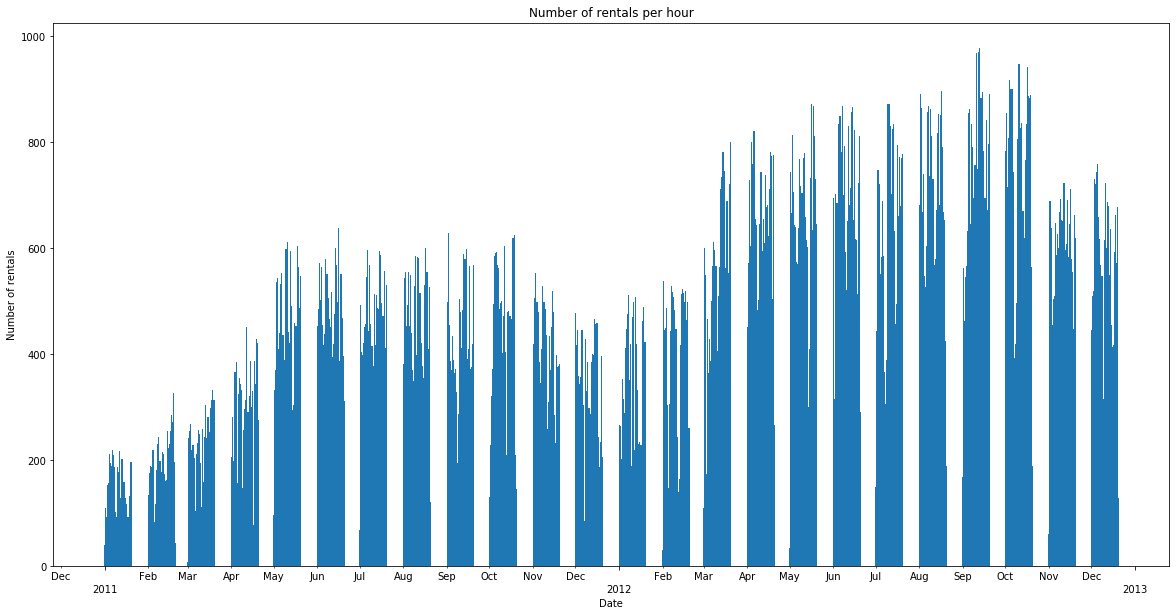

In [12]:
# Explicitly allow use of datetime format
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df['datetime'], df['count'])

ax.set_title('Number of rentals per hour')
ax.set_xlabel('Date')
ax.set_ylabel('Number of rentals')

# Set minor month ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
#set major year ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))

On observe tout d'abord que nous ne disposons pas de toutes les données. On ne dispose en effet que des données sur les 19 premiers jours de chaque mois, les jours restants sont en fait compris dans le test set dont nos données sont issues.

On remarque que la tendance est similaire sur l'année 2011 et l'année 2012, avec une augmentation globale en 2012. On observe également la forte influence des saisons. On observe certaines chutes ou pics, celles-ci sont probablement dues à des phénomènes ponctuels comme un week-end pluvieux.

On s'intéresse maintenant plus en détail aux évolutions journalières, mensuelles et annuelles. On remarque notamment que les locations ont majoritairement lieu aux horaires de pointe et durant la période estivale.

De manière générale le jour du mois n'influence pas sur le nombre de location, mais peut-être que le jour de la semaine influence.

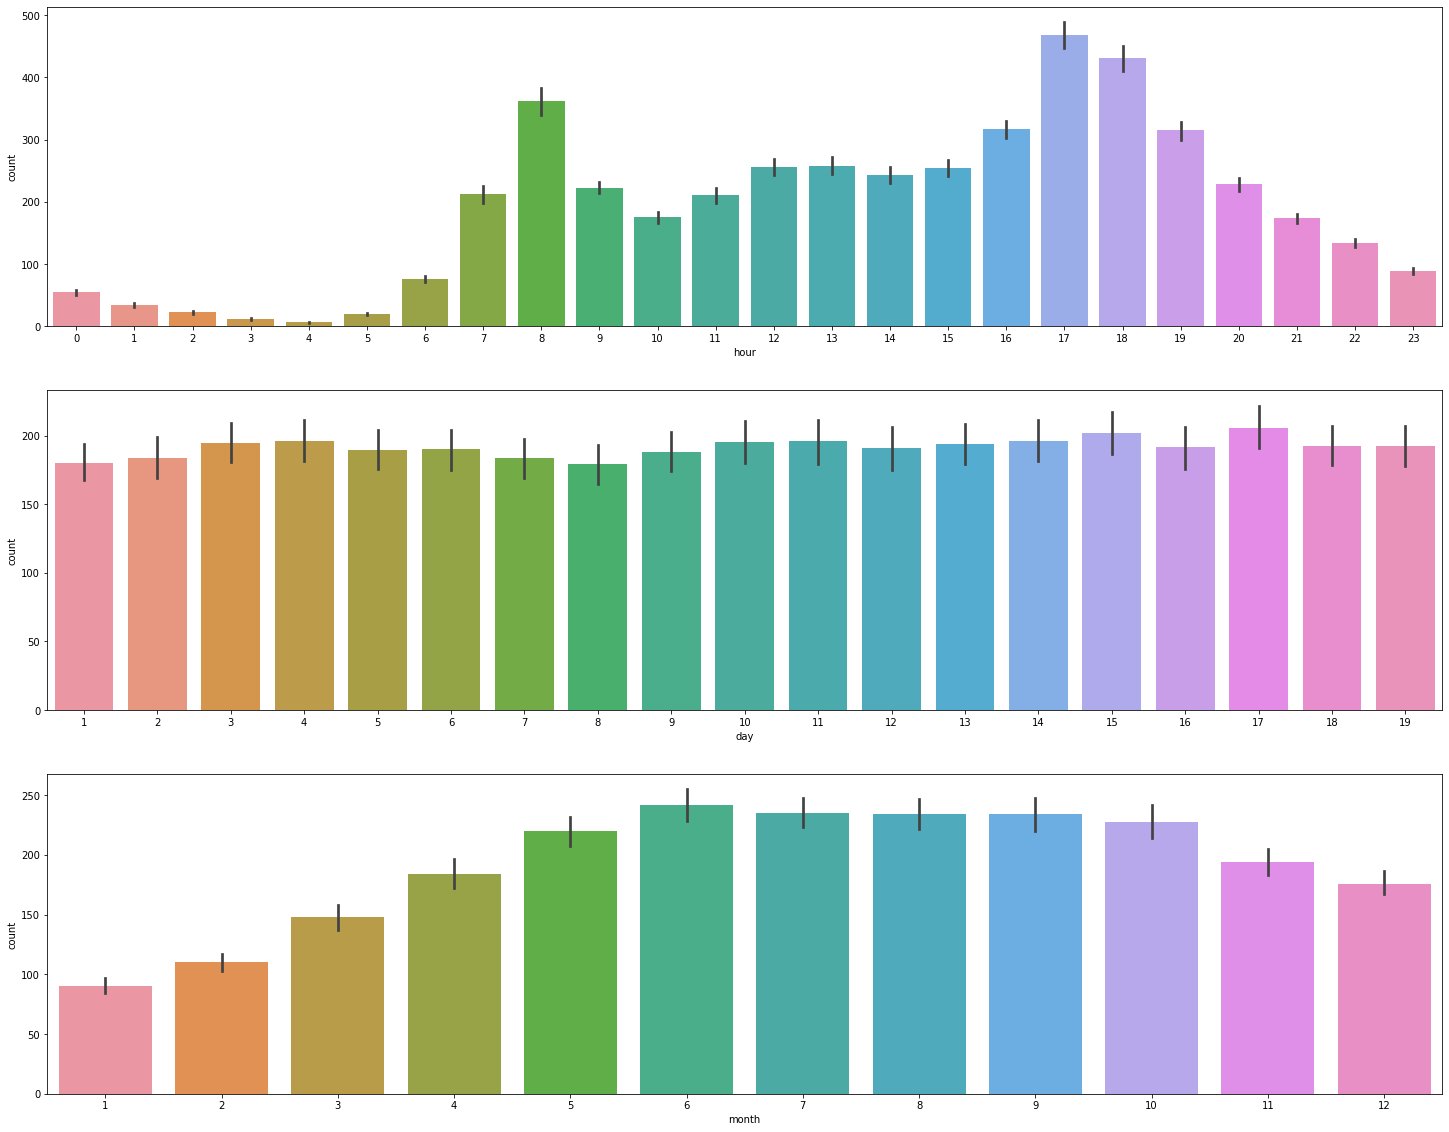

In [13]:
fig, ax = plt.subplots(3, 1,figsize=(25,20))

sns.barplot(x="hour",y="count",data=df,ax=ax[0])
sns.barplot(x="day",y="count",data=df,ax=ax[1])
sns.barplot(x="month",y="count",data=df,ax=ax[2])

plt.show()

On s'intéresse également à l'influence des jours fériés et des week-end.
Pour cela on calcule la moyenne des locations par heure en semaine et en week-end.

In [14]:
weekdayAggregation = pd.DataFrame(df.groupby(["hour","workingday"])["count"].mean()).reset_index()

weekdayAggregation.head()

,hour,workingday,count
0,0,0,94.489655
1,0,1,36.732258
2,1,0,71.910345
3,1,1,16.003236
4,2,0,53.748252


Il y a très peu de jours fériés, on retrouve la valeur de 2% des 365 jours

In [15]:
holydayAggregation = pd.DataFrame(df.groupby(["hour","holiday"])["count"].mean()).reset_index()

holidays = (df["holiday"] == 1) & (df["hour"] == 0)
df[holidays][["holiday","day","month","year"]]

,holiday,day,month,year
372,1,17,1,2011
1658,1,15,4,2011
2762,1,4,7,2011
3698,1,5,9,2011
4271,1,10,10,2011
4750,1,11,11,2011
5446,1,2,1,2012
5780,1,16,1,2012
7143,1,16,4,2012
8223,1,4,7,2012


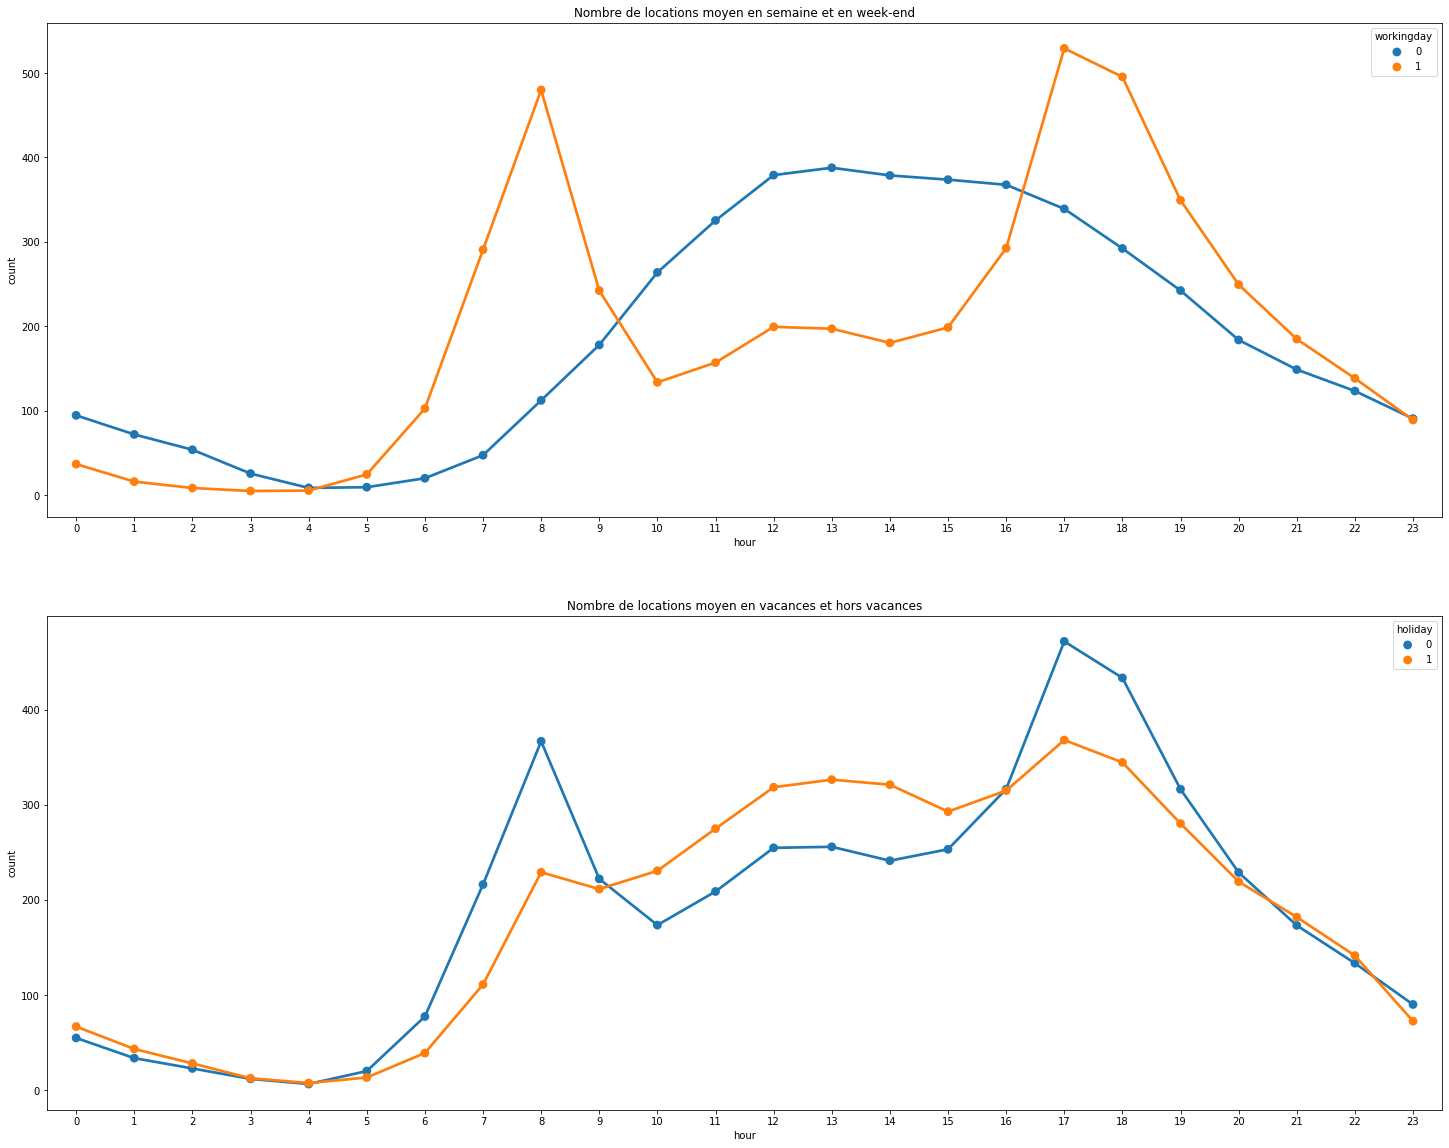

In [16]:
fig, ax = plt.subplots(2, 1,figsize=(25,20))
ax[0].set_title('Nombre de locations moyen en semaine et en week-end')
ax[1].set_title('Nombre de locations moyen en vacances et hors vacances')

sns.pointplot(
    x=weekdayAggregation["hour"],
    y=weekdayAggregation["count"],
    hue=weekdayAggregation["workingday"], 
    data=weekdayAggregation,
    join=True,
    ax=ax[0]
)
sns.pointplot(
    x=holydayAggregation["hour"],
    y=holydayAggregation["count"],
    hue=holydayAggregation["holiday"], 
    data=holydayAggregation,
    join=True,
    ax=ax[1]
)

plt.show()

Comme on pouvait s'y attendre, le comportement des utilisateurs est différent pendant les week-end.
On remarque que le comportement pendant les jours fériés correspond à un compromis entre jour de semaine et week-end.

On s'intéresse ensuite à la façon dont sont réparties les locations.

On remarque tout d'abord que la repartition est proportionnelle entre 2011 et 2012 comme vu précédemment. 
On voit aussi qu'un nombre élevé de locations en hiver (saison 1) et par temps de pluie (météo 3) correspond à des cas isolés : dans la majorité des cas le nombre de locations est proche de la valeur médiane et dans 50% des cas le nombre de locations n'excède pas 100

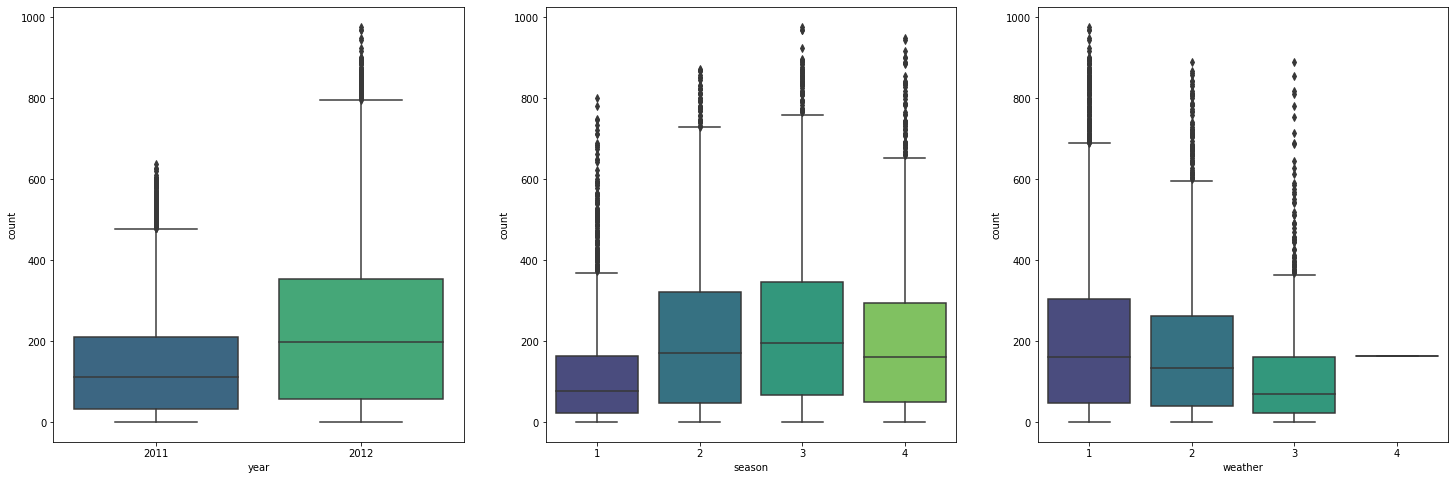

In [17]:
fig, ax = plt.subplots(1, 3,figsize=(25,8))

sns.boxplot(x="year", y="count", data=df, palette='viridis',ax=ax[0])
sns.boxplot(x="season", y="count", data=original_dataset, palette='viridis',ax=ax[1])
sns.boxplot(x="weather", y="count", data=df, palette='viridis',ax=ax[2])

plt.show()

En s'intéresse aux données météorologiques. Pour mieux comprendre les données on groupe les valeurs par tranches : par exemple des tranches de 5 degrés pour les températures. 

On remarque un comportement très similaire de temp et atemp. Comme attendu les jours très venteux il y a peu de locations.

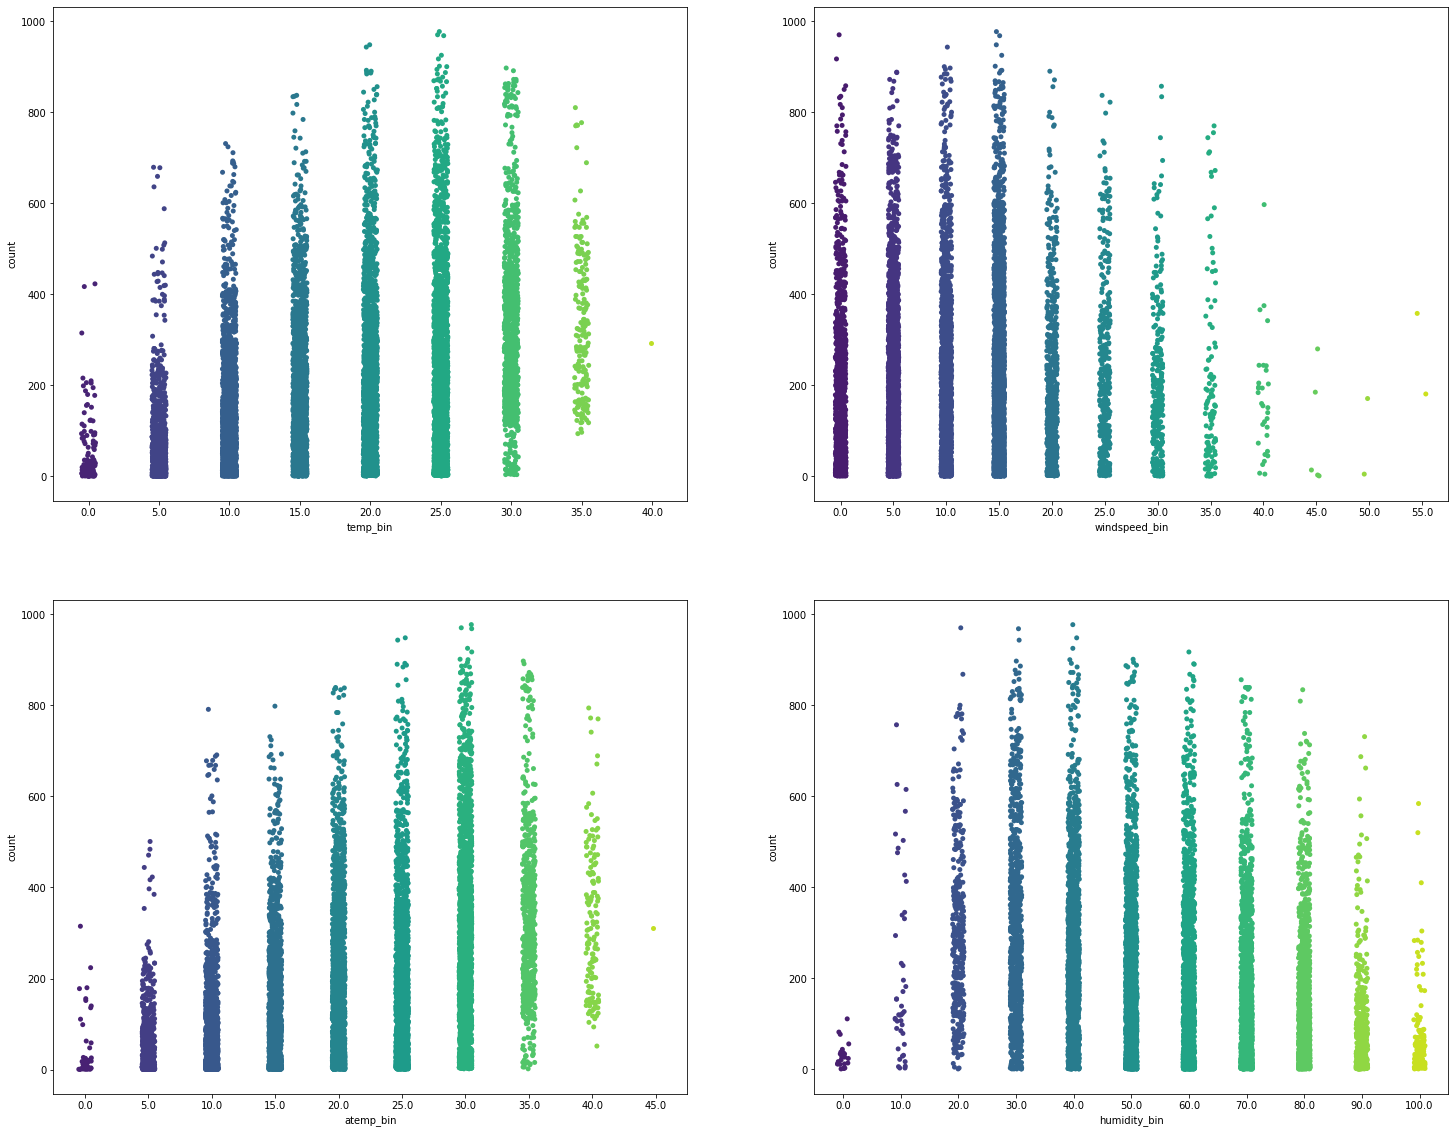

In [18]:
fig, ax = plt.subplots(2, 2,figsize=(25,20))

new_df=pd.DataFrame()
new_df['temp_bin']=5*(np.floor(df['temp'])//5)
new_df['atemp_bin']=5*(np.floor(original_dataset['atemp'])//5)
new_df['windspeed_bin']=5*(np.floor(df['windspeed'])//5)
new_df['humidity_bin']=10*(np.floor(df['humidity'])//10)
new_df['count']=df["count"]

sns.stripplot(x="temp_bin", y="count", data=new_df, palette='viridis',ax=ax[0,0])
sns.stripplot(x="atemp_bin", y="count", data=new_df, palette='viridis',ax=ax[1,0])
sns.stripplot(x="windspeed_bin", y="count", data=new_df, palette='viridis',ax=ax[0,1])
sns.stripplot(x="humidity_bin", y="count", data=new_df, palette='viridis',ax=ax[1,1])

plt.show()

### Matrice de corrélation
Cet outil est un bon moyen de voir les relations entre les données, notamment pour identifier les données inutiles et celles avec un forte influence.

In [19]:
dataset = df.copy()

dataset.drop(['datetime'],axis=1, inplace=True)
dataset.drop(['season'],axis=1, inplace=True)

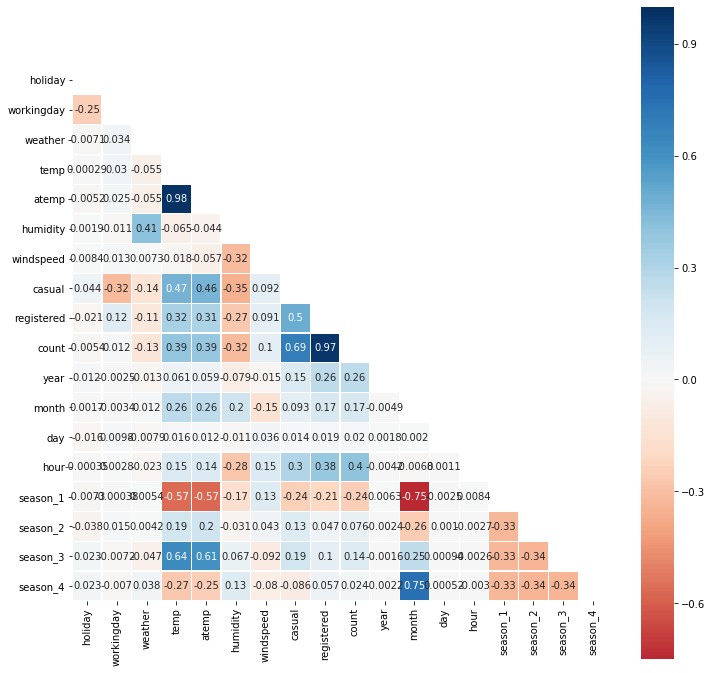

In [20]:
plt.figure(figsize=(12,12))
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(
    corr,
    mask=mask,
    cmap=plt.cm.RdBu,
    vmax=1.0,
    center=0,
    linewidths=0.1,
    linecolor='white',
    square=True,
    annot=True
)

On observe que les valeurs temp et atemp sont en effet très similaires et qu'il n'est pas utile de garder les deux.
On observe à nouveau que le jour du mois n'influe que peu le nombre de location. En revanche, bien que le paramètre workingday n'est pas l'air d'avoir d'influence, on sait qu'il influe sur les horaires auxquelles les vélos sont loués (les vélos ne sont plus loués au heures de pointes). On observe également que les saisons 1 et 3 (hiver et été) sont celles qui influent le plus sur le nombre de locations. 

In [21]:
dataset.drop(['holiday'],axis=1, inplace=True)
dataset.drop(['temp'],axis=1, inplace=True)
dataset.drop(['day'],axis=1, inplace=True)

### Résumé
Finalement nous avons :
- changé le format de certaines valeurs
- vérifié que le dataset n'avait pas de valeurs manquantes ou incohérentes
- mis en évidence les phénomènes périodiques influençant la location de vélo
- analysé l'impact de certaines valeurs sur le comportement des utilisateurs

## Features engineering
La fonction ci-dessous applique les différentes étapes de nettoyage de données que nous avons mis en place.

In [35]:
def features_engineering(df):
    
    # Replace season format with one hot encoding
    X = pd.concat([df, pd.get_dummies(df['season'], prefix='season')],axis=1)
    
    # Decompose date values in several features
    X['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%dT%H')

    X['year'] = X['datetime'].dt.year
    X['month'] = X['datetime'].dt.month
    X['day'] = X['datetime'].dt.day
    X['hour'] = X['datetime'].dt.hour
    
    # Drop replaced features
    X.drop(['datetime'],axis=1, inplace=True)
    X.drop(['season'],axis=1, inplace=True)
    
    # Drop uninteresting features
    X.drop(['holiday'],axis=1, inplace=True)
    X.drop(['temp'],axis=1, inplace=True)
    X.drop(['day'],axis=1, inplace=True)
    
    # Drop target value for train set
    X.drop(['count','casual','registered'],axis=1, inplace=True, errors='ignore')

    
    return X

In [36]:
# Clean dataset
X = features_engineering(original_dataset)
# Target
y = original_dataset["count"]

In [37]:
X.head()

,workingday,weather,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,year,month,hour
0,0,1,14.395,81,0.0,1,0,0,0,2011,1,0
1,0,1,13.635,80,0.0,1,0,0,0,2011,1,1
2,0,1,13.635,80,0.0,1,0,0,0,2011,1,2
3,0,1,14.395,75,0.0,1,0,0,0,2011,1,3
4,0,1,14.395,75,0.0,1,0,0,0,2011,1,4


Notre dataset est prêt pour l'entraînement.

## Modèle
Pour un problème de regression plusieurs algorithmes sont utilisables comme SVM, RandomForest ou ElasticNet.
J'ai ici choisi d'utiliser un modèle simple, le random forest qui est un algorithme d'ensemble learning qui a l'avantage de peu surapprendre (overfit) sur les données. Son fonctionnement basé sur des arbres de décisions permet de bien discriminer sur les features. Le modèle étant suffisament robuste, faire une cross validation n'est pas utile.

In [38]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn import metrics

On divise le dataset entre training et testing.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [40]:
# Define the regressor used
Regressor = RandomForestRegressor(n_estimators=500, criterion="mse")

On entraîne le modèle

In [41]:
model = Regressor.fit(X_train, y_train)

In [42]:
score_train = Regressor.score(X_train,y_train)*100
score_test = Regressor.score(X_test,y_test)*100

print("Accuracy on the training set %0.2f%%" % score_train)
print("Accuracy on the test set %0.2f%%" % score_test)
print()

predictions = Regressor.predict(X_test)
print('Mean Absolute Error: %0.2f' % metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error: %0.2f' % metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error: %0.2f' % np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('Root Mean Squared Logistic Error: %0.4f' % np.sqrt(metrics.mean_squared_log_error(y_test, predictions)))

Accuracy on the training set 99.15%
Accuracy on the test set 94.35%

Mean Absolute Error: 27.22
Mean Squared Error: 1822.95
Root Mean Squared Error: 42.70
Root Mean Squared Logistic Error: 0.3550


On voit tout d'aboird que la précision sur le test set est élevée et donc que le modèle n'a ni overfit ni underfit.

La MAE permet de bien comprendre l'importance de l'écart entre les valeurs prédites et actuelles. La valeur de RMSE obtenue montre que les écarts entre les valeurs prédites et actuels ne sont pas toujours constants mais les forts écarts plutôt rares.

Comme nous travaillons avec des valeurs allant jusqu'à 1000, utiliser le RMSLE permet de prendre en compte l'écart entre les valeurs prédites et actuelles de façon relative. (ex: entre 700 et 800 l'écart relatif est moins important qu'entre 50 et 150 alors que la différence est la même)

Pour référence le meilleur score obtenu sur kaggle est un RMSLE de 0.337 (sur le validation set). Un score de 0.362 correspond environ à la 15e place.
Le résultat présenté à bien sûr été obtenu sur le test set mais la robustesse du random forest lui permet de ne pas trop overfit.

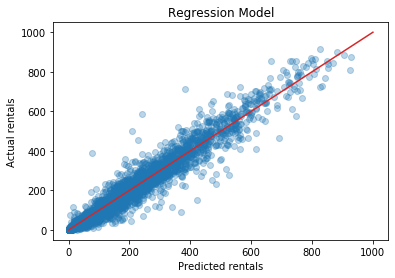

In [43]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.3, color='tab:blue') 
plt.plot([0,1000],[0,1000], color='tab:red')
plt.xlabel('Predicted rentals')
plt.ylabel('Actual rentals')
plt.title('Regression Model')
plt.show()

On observe que le modèle réussit à faire de bonnes prédictions de manière générale, les erreurs importantes correspondes à des valeurs isolées.

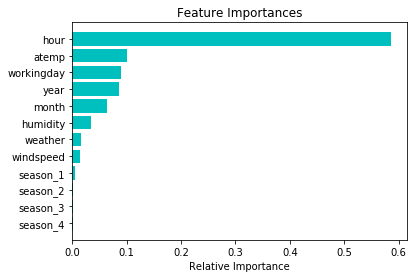

In [44]:
features = X.columns
importances = Regressor.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

On observe que le modèle pris en compte n'a que très peu pris en compte les valeurs de saison et plutôt considéré les valeurs de mois. La valeur d'humidité et la température semble également être les données météorologiques les plus importantes. Le critère d'heure est le plus important.

## Visualisation des prédictions
Afin d'avoir une idée plus visuelle du travail réalisé, j'ai récupéré le test set du challenge kaggle pour pouvoir tracer le nombre de locations prédit à côté des valeurs réelles.

In [45]:
validation_dataset = pd.read_csv("./data/test.csv")
X_validation = features_engineering(validation_dataset)

In [46]:
X_validation.head()

,workingday,weather,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,year,month,hour
0,1,1,11.365,56,26.0027,1,0,0,0,2011,1,0
1,1,1,13.635,56,0.0000,1,0,0,0,2011,1,1
2,1,1,13.635,56,0.0000,1,0,0,0,2011,1,2
3,1,1,12.880,56,11.0014,1,0,0,0,2011,1,3
4,1,1,12.880,56,11.0014,1,0,0,0,2011,1,4


In [50]:
validation_predictions = Regressor.predict(X_validation)
pred_val = pd.DataFrame({"datetime":validation_dataset['datetime'], "count":validation_predictions})

pred_val.head()

,datetime,count
0,2011-01-20 00:00:00,12.514000
1,2011-01-20 01:00:00,6.520667
2,2011-01-20 02:00:00,3.612000
3,2011-01-20 03:00:00,3.562000
4,2011-01-20 04:00:00,3.072000


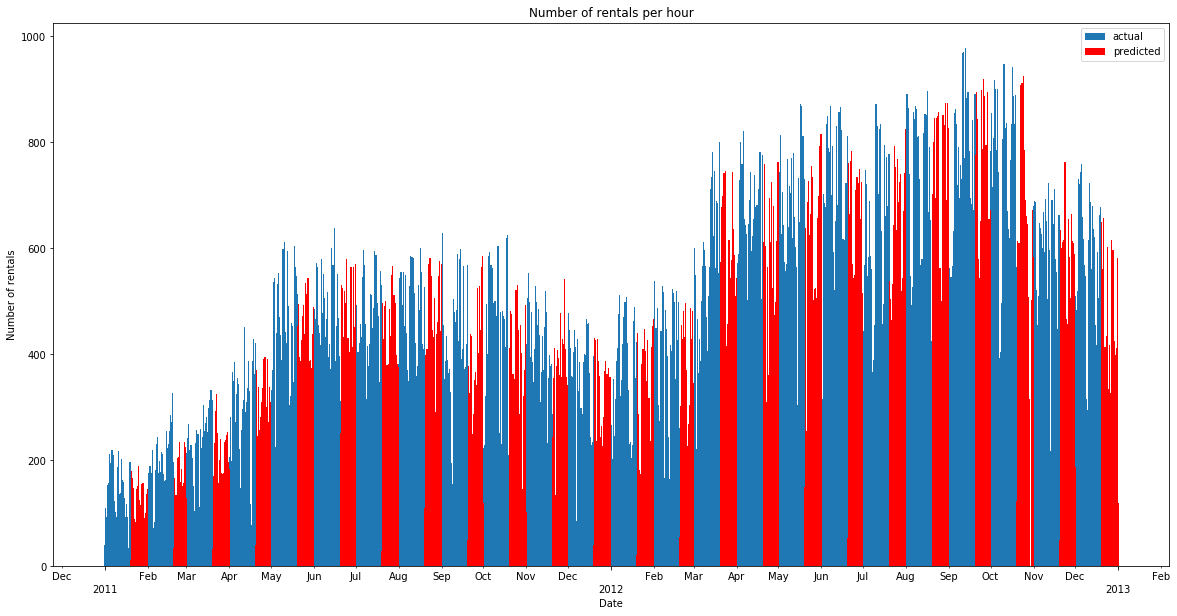

In [51]:
# Plot
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(df['datetime'], df['count'], color='tab:blue', label='actual')
ax.bar(validation_dataset['datetime'], pred_val['count'], color='r', label='predicted')

ax.set_title('Number of rentals per hour')
ax.set_xlabel('Date')
ax.set_ylabel('Number of rentals')
ax.legend()

# Set minor month ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
#set major year ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))

## Soumission

Génération des données prédites pour évaluation

In [52]:
pred_val.to_csv('Sample_submission.csv', index=False)

## Retour critique et améliorations
Bien que les résultats soient assez concluants, certains aspects peuvent bien sûr être améliorés.

Tout d'abord le dataset contient certaines données cycliques comme la colonne weather que nous avons utilisé avec un encodage one hot. Une autre solution, également applicable aux colonnes month, day, hour ou encore season, serait de projeter ces données sur deux dimensions, par exemple à l'aide des fonctions sinus et cosinus.

Il est également à noter que le type de données manipulé est assez spécifique. Une autre manière très interessante de traiter ce problème aurait été d'utiliser des méthodes de Time Series Analysis. En effet, utiliser une méthode telle qu'un LSTM est très efficace pour ce type de données séquentielles. La particularité de cette méthode repose sur sa capacité à repérer des tendances dans les données et permet d'identifier les phénomènes périodiques. Elle est notamment utilisée dans la prédiction du cours des actions, dans notre cas nous aurions pu l'utiliser pour prédire les locations de vélos début 2013 directement en lien avec les évènements de fin 2012.

On notera également que le dataset fourni ne comportait pas beaucoup d'erreurs, ce qui n'est pas toujours le cas. En cas de manque de données, il aurait été éventuellement possible de récupérer les données méteorologiques des années suivantes pour compléter le dataset.